In [1]:
import time
import numpy as np
from data.sp_data import SPData
from models import SPQuboBinary, SPCplex
from evaluation.evaluation import SPEvaluation
from plotting.sp_plot import SPPlot
from tqdm import tqdm
import pickle

import os
import matplotlib.pyplot as plt
#from dotenv import load_dotenv

import luna_sdk
from luna_sdk import LunaSolve
from luna_sdk.schemas.qpu_token import QpuToken, TokenProvider

In [2]:
os.environ["LUNA_ENCRYPTION_KEY"] = "2z+TiZGBeyjZKuctYvMQQLkYbKZgUuXPgd2tpTyxIUE="
os.environ["LUNA_DWAVE_TOKEN"] = "newtoken"

In [3]:
complexity_arr = [1, 5, 10, 50, 100, 300]

version_1_samples = [SPData().gen_problem(version=1, num_cols=i, rad_max=2.4) for i in complexity_arr]
version_2_samples = [SPData().gen_problem(version=2, num_cols=i, rad_max=2.4) for i in complexity_arr]
version_3_samples = [SPData().gen_problem(version=3, num_cols=i, rad_max=2.4) for i in complexity_arr]

version_samples = (version_1_samples, version_2_samples, version_3_samples)

In [4]:
version_1_qubo_binary_matrix = [SPQuboBinary(data, P1=1, P2=1, P3=1).model for data in version_1_samples]
version_2_qubo_binary_matrix = [SPQuboBinary(data, P1=1, P2=1, P3=1).model for data in version_2_samples]
version_3_qubo_binary_matrix = [SPQuboBinary(data, P1=1, P2=1, P3=1).model for data in version_3_samples]
version_matrix = (version_1_qubo_binary_matrix, version_2_qubo_binary_matrix, version_3_qubo_binary_matrix)

In [5]:
classic_alg_energy = ([], [], [])
for version in range(3):
    for data in version_samples[version]:
        cplex_model = SPCplex(data)
        answer = cplex_model.solve()
        x = list(answer['solution'].values())
        classic_alg_energy[version].append(sum(x))

# Luna Simulations

In [6]:
# set up luna solve
ls = LunaSolve(api_key="53741991842f4da8b7962859296e2643")

## Algorithm benchmarking

In [7]:
q_anneal_test_list = [('QA', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    ('RRQA', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    ('PAQ', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    ('PTQ', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    ('QLQ', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    ('K', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token")))]
                    #('LBQM', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    #('LCQM', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token")))]


sim_anneal_test_list = [('SA', 'dwave', None), 
                        ('PA', 'dwave', None),
                        ('PT', 'dwave', None),
                        ('RRSA', 'dwave', None),
                        ('QLSA', 'dwave', None)]



gen_alg_test_list = [('QAGA+', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    ('QAGA_PL', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    ('QAGA_PW', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="dwave-token"))),
                    ('SAGA+', 'dwave', None),
                    ('SAGA_PL', 'dwave', None),
                    ('SAGA_PW', 'dwave', None)]

In [8]:
def simulate_luna(tuple, Q):

    optimization = ls.optimization.create_from_qubo(name="qubo_test", matrix=Q)

    job = ls.solution.create(
            optimization_id=optimization.id,
            solver_name=tuple[0],
            provider=tuple[1],
            qpu_tokens=tuple[2],
        )
    
    solution = ls.solution.get(job.id)
    
    xi_list = []
    
    while not solution.results:
        time.sleep(5)
        solution = ls.solution.get(job.id)

    

    xi_list = [ np.array(list(solution.results[i].sample.values())) for i  in range(len(solution.results)) ]

    energy_list = [x.T @ Q @ x for x in xi_list]
    
    # quantum/classical runtime
    total_time = solution.runtime.total
    qpu_time = solution.runtime.qpu

    return xi_list, energy_list, total_time, qpu_time

### Genetic Algorithms

In [57]:
"""
gen_alg_res_list = []

for alg in tqdm([gen_alg_test_list[3]]):
    
    gen_alg_res_list.append(simulate_luna(alg, optimization, Q_test))

with open('gen_alg_res_list.pkl', 'wb') as f:
    pickle.dump(gen_alg_res_list, f)
"""

"\ngen_alg_res_list = []\n\nfor alg in tqdm([gen_alg_test_list[3]]):\n    \n    gen_alg_res_list.append(simulate_luna(alg, optimization, Q_test))\n\nwith open('gen_alg_res_list.pkl', 'wb') as f:\n    pickle.dump(gen_alg_res_list, f)\n"

In [16]:
# we simulate all algorithms for this Q matrix (10 Lidar's)
Q_test = version_3_qubo_binary_matrix[-1]
energy_reference = classic_alg_energy[2][-1]

### Simulated Annealing

In [59]:
sim_anneal_res_list = []

for alg in tqdm(sim_anneal_test_list):
    
    sim_anneal_res_list.append(simulate_luna(alg, Q_test))


with open('sim_anneal_res_list.pkl', 'wb') as f:
    pickle.dump(sim_anneal_res_list, f)

100%|██████████| 5/5 [02:46<00:00, 33.40s/it]


### Quantum Annealing

In [61]:
"""
q_anneal_res_list = []

for alg in tqdm(q_anneal_test_list):
    
    q_anneal_res_list.append(simulate_luna(alg, optimization, Q_test))


with open('q_anneal_res_list.pkl', 'wb') as f:
    pickle.dump(q_anneal_res_list, f)
"""

"\nq_anneal_res_list = []\n\nfor alg in tqdm(q_anneal_test_list):\n    \n    q_anneal_res_list.append(simulate_luna(alg, optimization, Q_test))\n\n\nwith open('q_anneal_res_list.pkl', 'wb') as f:\n    pickle.dump(q_anneal_res_list, f)\n"

## Sort results

In [9]:
#with open('gen_alg_res_list.pkl', 'rb') as f:
#    gen_alg_res_list = pickle.load(f)

with open('sim_anneal_res_list.pkl', 'rb') as f:
    sim_anneal_res_list = pickle.load(f)

#with open('q_anneal_res_list.pkl', 'rb') as f:
#    q_anneal_res_list = pickle.load(f)

In [10]:
results = sim_anneal_res_list

alg_names = [ alg[0] for alg in sim_anneal_test_list ]
min_energies = []
runtimes = []
lidar_counts = []

for result in results:
    min_energies.append(min(result[1]))
    runtimes.append(result[2])
    min_idx = np.argmin(result[1])
    lidar_counts.append(sum(result[0][min_idx][:complexity_arr[-1]]))

In [11]:
sorted_indices = np.argsort(np.array(min_energies)), 

min_energy = np.array(min_energies)[sorted_indices]
runtime = np.array(runtimes)[sorted_indices]
lidar_count = np.array(lidar_counts)[sorted_indices]
alg_names = np.array(np.array(alg_names)[sorted_indices], dtype=object)

# Plots

In [17]:
# colors
color_red = "#e64b35"
color_light_red = "#f39b7f"
color_green = "#00a087"
color_lightblue = "#4dbbd5"
color_blue = "#3c5488"
colors = [color_blue, color_lightblue, color_green, color_light_red, color_red]

In [18]:
["cplex"] + alg_names

NameError: name 'alg_names' is not defined

In [14]:
np.insert(alg_names, 0,np.array(['cplex']))

array(['cplex', 'PT', 'QLSA', 'RRSA', 'SA', 'PA'], dtype=object)

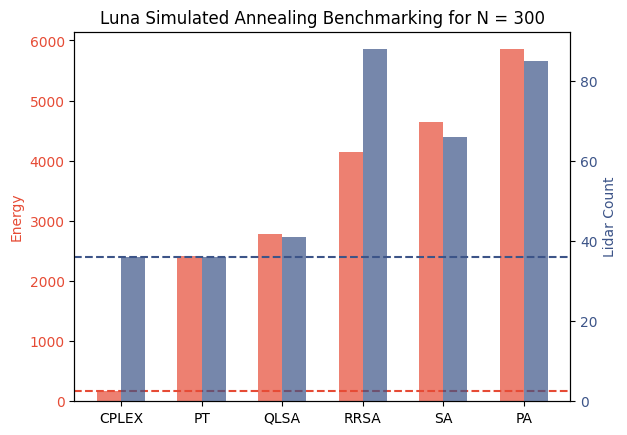

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = np.insert(alg_names, 0,["CPLEX"])
values1 = np.insert(min_energy, 0 ,energy_reference)  # Data for the first bar plot
values2 = np.insert(lidar_count, 0 ,lidar_count[0])   # Data for the second bar plot

# Bar width
bar_width = 0.3

# X positions
x = np.arange(len(categories))

# Create the figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first set of bars
bars1 = ax1.bar(x - bar_width/2, values1, bar_width, alpha=0.7, color=colors[4])
ax1.set_ylabel('Energy', color=colors[4])
ax1.tick_params(axis='y', labelcolor=colors[4])

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second set of bars
bars2 = ax2.bar(x + bar_width/2, values2, bar_width, alpha=0.7, color=colors[0])
ax2.set_ylabel('Lidar Count', color=colors[0])
ax2.tick_params(axis='y', labelcolor=colors[0])

# Add labels and title
ax1.set_xticks(x)
ax1.set_xticklabels(categories)

ax1.axhline(y=energy_reference, color=colors[4], linestyle='--')

ax2.axhline(y=lidar_count[0], color=colors[0], linestyle='--')

ax1.set_title('Luna Simulated Annealing Benchmarking for N = 300')
fig.savefig('benchmark1.pdf')
# Display the plot
plt.show()


# Benchmark PT over N and compare with QPT

In [39]:
complexities = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

var_3_samples = [SPData().gen_problem(version=3, num_cols=i, rad_max=2.4) for i in complexities]
var_3_qubo_binary_matrix = [SPQuboBinary(data, P1=1, P2=1, P3=1).model for data in var_3_samples]

In [40]:
benchmark_PT_list = []

for i,comp in tqdm(enumerate(complexities), total=len(complexities)):
    benchmark_PT_list.append(simulate_luna(('PT', 'dwave', None), var_3_qubo_binary_matrix[i]))


with open('benchmark_PT_list.pkl', 'wb') as f:
    pickle.dump(benchmark_PT_list, f)

100%|██████████| 11/11 [01:25<00:00,  7.78s/it]


In [41]:
benchmark_PTQ_list = []


for i,comp in tqdm(enumerate(complexities), total=len(complexities)):
    benchmark_PTQ_list.append(simulate_luna(('PTQ', 'dwave', TokenProvider(dwave=QpuToken(source="inline",token="DEV-b9e91fad6a014c54d02857bb83e4b1003f28e02a"))), var_3_qubo_binary_matrix[i]))

with open('benchmark_PTQ_list.pkl', 'wb') as f:
    pickle.dump(benchmark_PTQ_list, f)

100%|██████████| 11/11 [02:25<00:00, 13.19s/it]


In [42]:
with open('benchmark_PT_list.pkl', 'rb') as f:
    benchmark_PT_list = pickle.load(f)

with open('benchmark_PTQ_list.pkl', 'rb') as f:
    benchmark_PTQ_list = pickle.load(f)

### CPLEX

In [43]:
cplex_solve_times = []
cplex_sol = []

for data in var_3_samples:
    # Start the timer
    start_time = time.time()
    
    # Create and solve the CPLEX model
    cplex_model = SPCplex(data)
    answer = cplex_model.solve()
    
    # Stop the timer
    elapsed_time = time.time() - start_time
    cplex_solve_times.append(elapsed_time)
    
    # Retrieve the solution and calculate its sum
    x = list(answer['solution'].values())
    cplex_sol.append(sum(x))

# Plot results

In [44]:
min_energiesC = []
runtimesC = []
lidar_countsC = []


for i in range(len(benchmark_PT_list)):
    result = benchmark_PT_list[i]
    min_energiesC.append(min(result[1]))
    runtimesC.append(result[2])
    min_idx = np.argmin(result[1])
    lidar_countsC.append(sum(result[0][min_idx][:complexities[i]]))

In [45]:
min_energiesQ = []
runtimesQ = []
lidar_countsQ = []

for i in range(len(benchmark_PTQ_list)):
    result = benchmark_PTQ_list[i]

    min_energiesQ.append(min(result[1]))
    runtimesQ.append(result[2])
    min_idx = np.argmin(result[1])
    lidar_countsQ.append(sum(result[0][min_idx][:complexities[i]]))

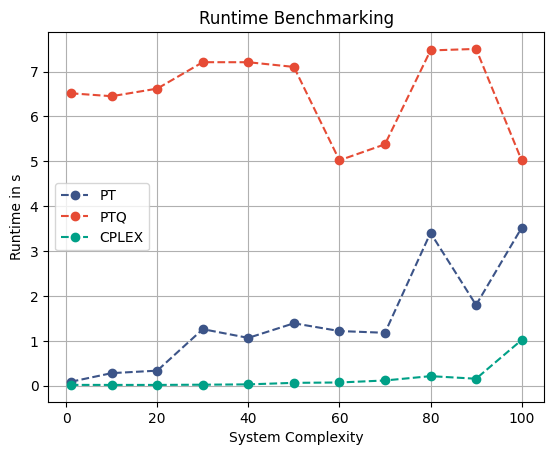

In [46]:
fig, ax = plt.subplots()

ax.plot(complexities, runtimesC, marker='o', linestyle = 'dashed', color = colors[0], label = 'PT')
ax.plot(complexities, runtimesQ, marker='o', linestyle = 'dashed', color = colors[4], label = 'PTQ')
ax.plot(complexities, cplex_solve_times, marker='o', linestyle = 'dashed', color = colors[2], label = 'CPLEX')
ax.grid(True)
ax.set_xlabel('System Complexity')
ax.set_ylabel('Runtime in s')
ax.set_title('Runtime Benchmarking')
ax.legend()

fig.savefig('runtime.pdf')

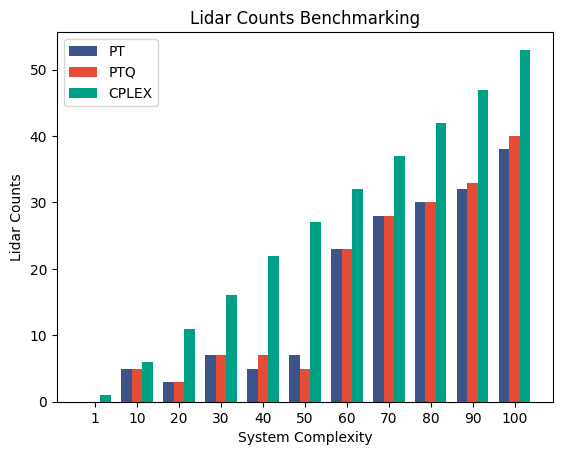

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assumed data (please replace 'complexities', 'lidar_countsC', and 'lidar_countsQ' with your actual data)
# complexities = ['Low', 'Medium', 'High', 'Very High']  # example categories for system complexity
# lidar_countsC = [data for your PT counts]
# lidar_countsQ = [data for your PTQ counts]


# The positions of the x-axis ticks (the center of the bars as per each category)
x = np.arange(len(complexities))  # array of x positions for each group of bars

# Setting the width for each bar
width = 0.25

fig, ax = plt.subplots()

# Creating bars for each group
bars1 = ax.bar(x - width, lidar_countsC, width, label='PT', color=colors[0])
bars2 = ax.bar(x , lidar_countsQ, width, label='PTQ', color=colors[4])
bars3 = ax.bar(x + width, cplex_sol, width, label='CPLEX', color=colors[2])

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('System Complexity')
ax.set_ylabel('Lidar Counts')
ax.set_title('Lidar Counts Benchmarking')
ax.set_xticks(x)
ax.set_xticklabels(complexities)
ax.legend()
# Display the plot
plt.show()


fig.savefig('lidar_counts.pdf')
